In [34]:
import pandas as pd
import folium
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import csv
import branca.colormap as cm

In [ ]:
data = pd.read_csv('data.csv')
data = data.rename(columns={'opis': 'natezenie'})

data[['lat', 'lon']] = data['WKT'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
data['lon'] = data['lon'].astype(float)
data['lat'] = data['lat'].astype(float)

filteredData = data[data['natezenie'].notna()]
filteredData['natezenie'] = filteredData['natezenie'].astype(float)

In [36]:
my_inten = np.array([30.6, 57.9, 73.5, 81.6, 88.2])
ref_inten = np.array([25.5, 54.3, 67.1, 76.9, 81.4])

In [37]:
def calibration_curve(intensity, a, b, c):
    return a*np.power(intensity, 2) + b*intensity + c

[-1.85513204e-03  1.19296051e+00 -9.17242976e+00]


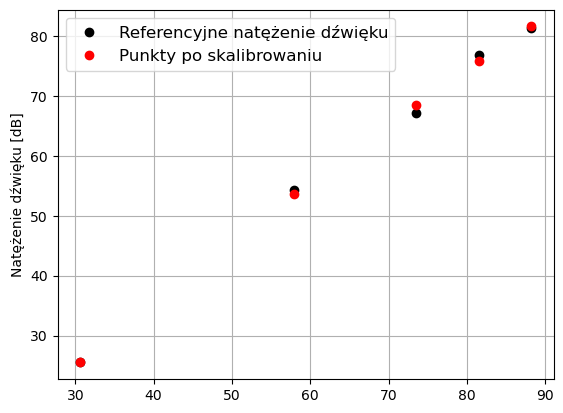

In [49]:
popt, _ = curve_fit(calibration_curve, xdata = my_inten, ydata = ref_inten, p0=[0.1, 0.5, 1])
print(popt)
plt.plot(my_inten, ref_inten, marker = 'o', linestyle = '', color = 'black', label = "Referencyjne natężenie dźwięku")
plt.plot(my_inten, calibration_curve(my_inten, popt[0], popt[1], popt[2]), marker = 'o', linestyle = '', color = 'red', label = "Punkty po skalibrowaniu")
plt.ylabel("Natężenie dźwięku [dB]")
plt.legend(fontsize = 12)
plt.grid()

In [39]:
filteredData['natezenie'] = calibration_curve(filteredData['natezenie'], popt[0], popt[1], popt[2])

In [40]:
intensity = []
longitude = []
latitude = []
modeledData = [intensity, longitude, latitude]

for i in range(len(filteredData['natezenie']) - 1): 
    intensity.append(filteredData['natezenie'][i])
    intensityMean = 0.5 * (filteredData['natezenie'][i] + filteredData['natezenie'][i+1])
    intensity.append(intensityMean)

    longitude.append(filteredData['lon'][i])
    longitudeMean = 0.5 * (filteredData['lon'][i] + filteredData['lon'][i+1])
    longitude.append(longitudeMean)
    
    latitude.append(filteredData['lat'][i])
    latitudeMean = 0.5 * (filteredData['lat'][i] + filteredData['lat'][i+1])
    latitude.append(latitudeMean)

filename = "interpolated_data.csv"
with open(filename, mode = "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerows(list(zip(*modeledData)))

In [ ]:
import folium.plugins


JORDAN_LOC = [50.063143, 19.916243]
map = folium.Map(location = JORDAN_LOC, zoom_start = 17)

colormap = cm.LinearColormap(colors = ["green", "orange", "red"], vmin = 35, vmax = 80)
colormap.caption = "Natężenie dźwięku [dB]"
colormap.height = 50
colormap.width = 600

for i in range(np.int16(np.size(modeledData)/3)):
    color = colormap(modeledData[0][i]) #natezenie-kolor
    folium.CircleMarker(
        location = [modeledData[1][i], modeledData[2][i]], #lon, lat
        radius = 10,
        color = color,
        fill = True,
        fill_color = color,
        fill_opacity = 0.8
    ).add_to(map)

colormap.add_to(map)
map.save("mapa_hałasu.html")
map